# Assignment Question: UScrime Bayesian Linear Models

Download the CSV file UScrime.csv from Canvas. The dataset contains crime rates (y) and data on 15 explanatory variables for 47 U.S. states. A description of the variables is provided in Table 1.

## Questions

**(a)** Fit a Bayesian linear regression model using noninformative priors. Obtain marginal posterior means and 95% credible intervals for coefficients. Describe the relationships between crime and the explanatory variables. Which variables seem strongly predictive of crime rates?

**(b)** To test how well regression models can predict crime rates based on the explanatory variables, randomly divide the data roughly in half, into training set and a test set. Use the training dataset to fit the model and generate the posterior predictive median of the crime rates given the explanatory variables in the test dataset. Compare the posterior predictive median and the actual crime rate in the test dataset.

**(c)** Repeat Parts (a) and (b) using spike-and-slab priors for regression coefficients.

---

This notebook provides a rigorous end-to-end workflow for the UScrime dataset. It includes:

1. Setup and reproducibility
2. Data loading, checks, and tidy preprocessing
3. Exploratory analysis (seaborn)
4. **Model A:** Conjugate Bayesian linear regression with noninformative prior
5. **Model B:** Spike-and-slab selection (PyMC; Bernoulli indicators)
6. Train/test predictive evaluation
7. Model diagnostics and comparison (posterior summaries, PSIS-LOO)
8. Conclusions

Notes
- Predictors are standardized (mean 0, SD 1). Coefficients read as change in crime rate per 1 SD increase in the predictor.
- For spike-and-slab, we report posterior inclusion probabilities and coefficient intervals based on the slab.
- All code is PEP 8 friendly, ASCII-only, and type hinted.


In [1]:
%pip install pymc arviz seaborn

from __future__ import annotations

from dataclasses import dataclass
from typing import Dict, Iterable, List, Tuple

import warnings

# Suppress ipywidgets warning from rich library (set before PyMC import)
warnings.filterwarnings("ignore", message=".*install.*ipywidgets.*", category=UserWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from numpy.linalg import inv
from scipy.stats import t as student_t

# Set seaborn theme for clean, professional plots
sns.set_theme(style="whitegrid", context="talk", palette="husl")
plt.rcParams.update({
    "figure.autolayout": True,
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.titlesize": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans", "Helvetica", "sans-serif"]
})

RNG_SEED: int = 2025
rng: np.random.Generator = np.random.default_rng(RNG_SEED)

pd.options.display.float_format = "{:0.3f}".format


Note: you may need to restart the kernel to use updated packages.


In [2]:
PREDICTORS: List[str] = [
    "M", "So", "Ed", "Po1", "Po2", "LF", "M.F", "Pop", "NW", "U1",
    "U2", "GDP", "Ineq", "Prob", "Time"
]
Y_COL: str = "y"


@dataclass
class Standardizer:
    mean: pd.Series
    std: pd.Series

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        z = (X - self.mean) / self.std.replace(0, 1.0)
        return z

    @classmethod
    def fit(cls, X: pd.DataFrame) -> "Standardizer":
        return cls(mean=X.mean(), std=X.std(ddof=1))


def load_uscrime(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    needed = set([Y_COL] + PREDICTORS)
    missing = needed.difference(df.columns.tolist())
    if missing:
        raise ValueError(f"Missing columns: {sorted(missing)}")
    return df


def train_test_split(
    n: int, rng: np.random.Generator, frac: float = 0.5
) -> Tuple[np.ndarray, np.ndarray]:
    idx = np.arange(n)
    rng.shuffle(idx)
    split = int(np.round(frac * n))
    return idx[:split], idx[split:]


## 1. Load and explore

We examine basic distributions and bivariate structure before modeling.


,Unnamed: 0,M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,GDP,Ineq,Prob,Time,y
0,1,151,1,91,58,56,510,950,33,301,108,41,394,261,0.085,26.201,791
1,2,143,0,113,103,95,583,1012,13,102,96,36,557,194,0.030,25.300,1635
2,3,142,1,89,45,44,533,969,18,219,94,33,318,250,0.083,24.301,578
3,4,136,0,121,149,141,577,994,157,80,102,39,673,167,0.016,29.901,1969
4,5,141,0,121,109,101,591,985,18,30,91,20,578,174,0.041,21.300,1234


,count,mean,std,min,25%,50%,75%,max
y,47.000,905.085,386.763,342.000,658.500,831.000,1057.500,1993.000
M,47.000,138.574,12.568,119.000,130.000,136.000,146.000,177.000
So,47.000,0.340,0.479,0.000,0.000,0.000,1.000,1.000
Ed,47.000,105.638,11.187,87.000,97.500,108.000,114.500,122.000
Po1,47.000,85.000,29.719,45.000,62.500,78.000,104.500,166.000
Po2,47.000,80.234,27.961,41.000,58.500,73.000,97.000,157.000
LF,47.000,561.191,40.412,480.000,530.500,560.000,593.000,641.000
M.F,47.000,983.021,29.467,934.000,964.500,977.000,992.000,1071.000
Pop,47.000,36.617,38.071,3.000,10.000,25.000,41.500,168.000
NW,47.000,101.128,102.829,2.000,24.000,76.000,132.500,423.000


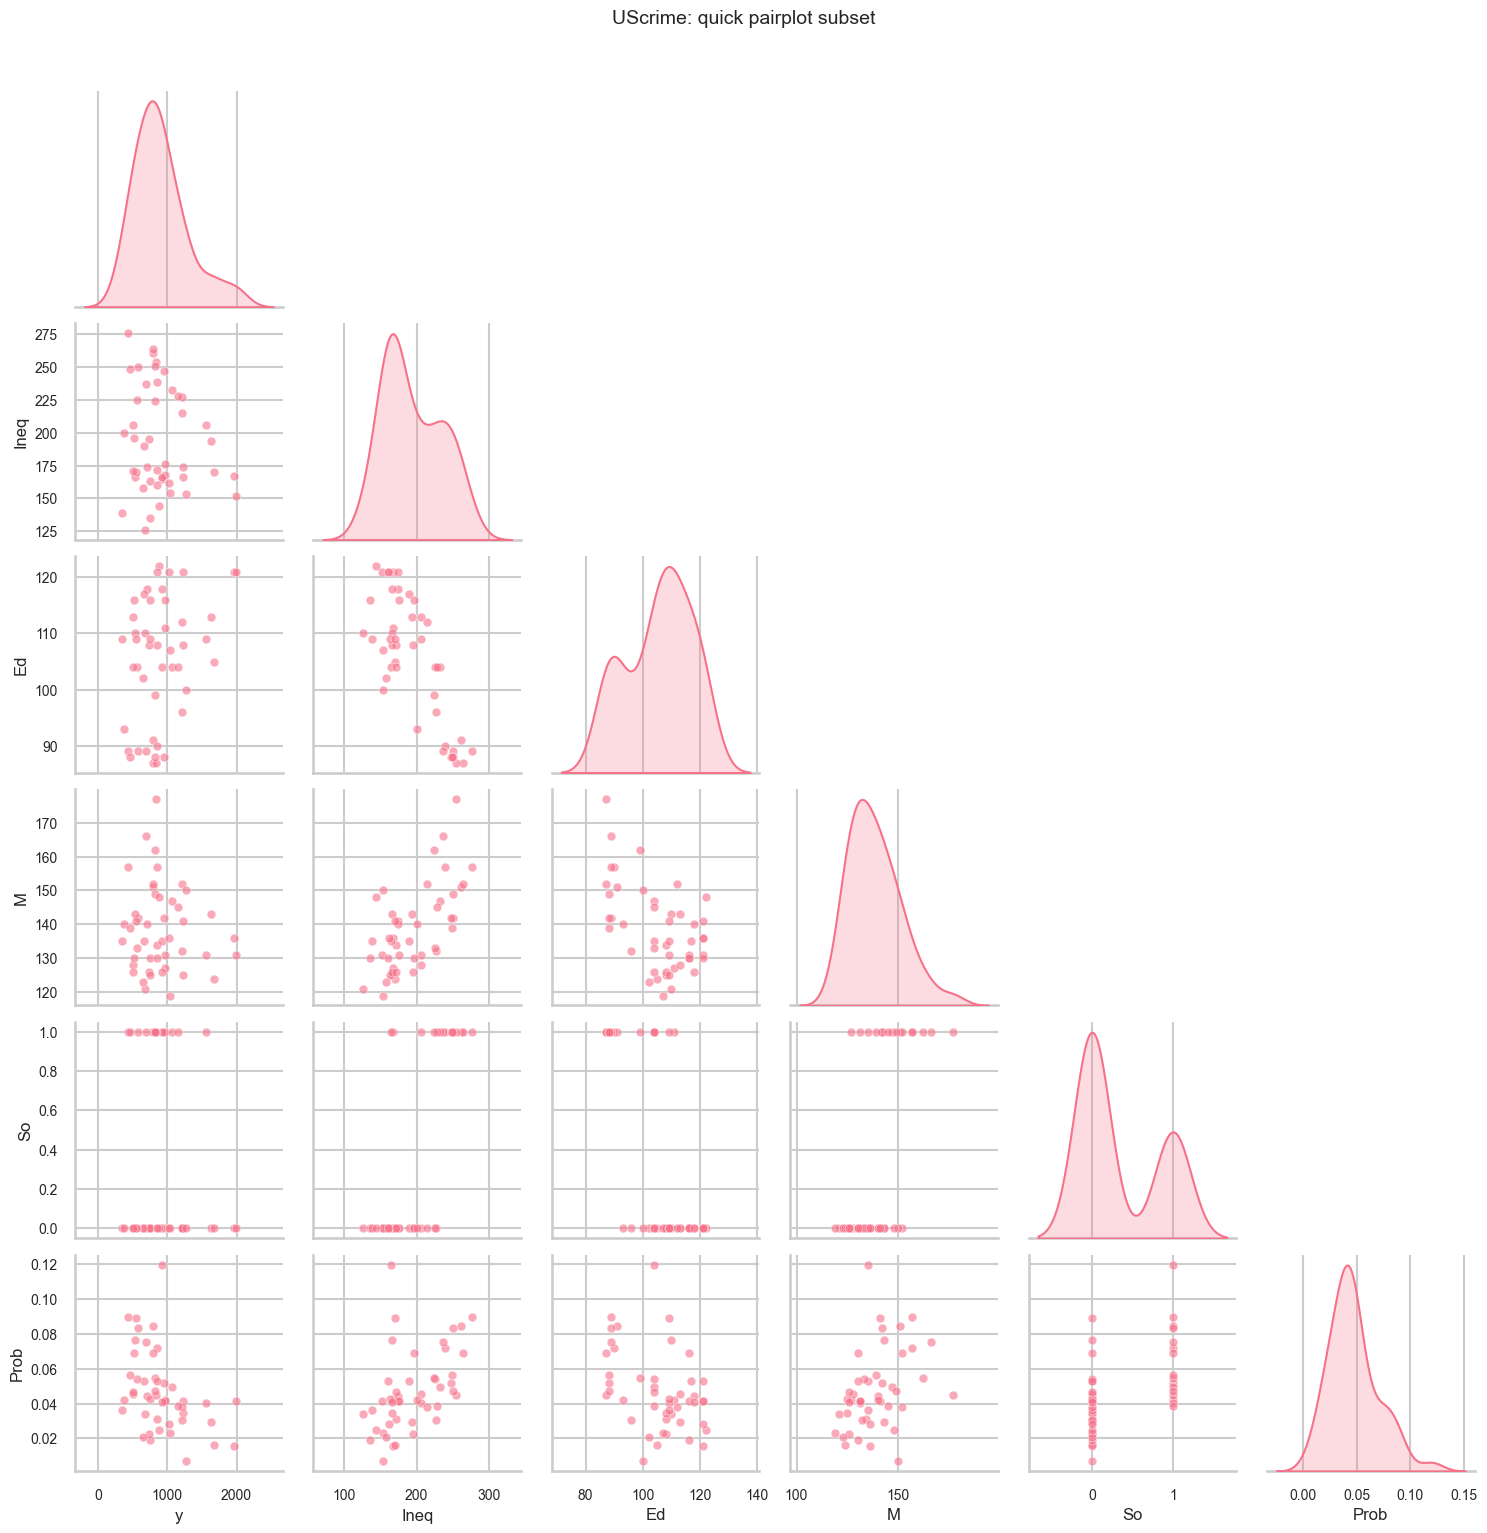

In [3]:
# Load
df = load_uscrime("../data/UScrime.csv")
display(df.head())

# EDA: summaries
desc = df[[Y_COL] + PREDICTORS].describe().T
display(desc)

# EDA: seaborn pairplot on a subset to avoid clutter
subset_vars = [Y_COL, "Ineq", "Ed", "M", "So", "Prob"]
g = sns.pairplot(df[subset_vars], diag_kind="kde", corner=True, plot_kws={"alpha": 0.6, "s": 40})
g.fig.suptitle("UScrime: quick pairplot subset", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


## 2. Preprocess

Standardize predictors (mean 0, SD 1) for numerical stability and
interpretability. Keep `y` in original units.


In [4]:
# Extract predictor matrix and response vector
X = df[PREDICTORS].copy()
y = df[Y_COL].astype(float).to_numpy()
n = len(y)

# Standardize predictors (mean 0, SD 1) for numerical stability
standardizer = Standardizer.fit(X)
Z = standardizer.transform(X)
Z_np = Z.to_numpy()

# Add intercept column for conjugate Bayesian linear regression
X_design = np.column_stack([np.ones(n), Z_np])
k = X_design.shape[1]  # Number of coefficients (intercept + p predictors)


## Answer to Question (a): Bayesian linear regression with noninformative priors

We fit a Bayesian linear regression model using noninformative priors. We obtain marginal posterior means and 95% credible intervals for coefficients, describe the relationships between crime and the explanatory variables, and identify which variables seem strongly predictive of crime rates.


## 3. Model A: Conjugate Bayesian linear regression

We use the standard improper prior `p(beta, sigma^2) ∝ 1/sigma^2`.
Posterior for `beta` is multivariate Student t. This yields closed-form
credible intervals and predictive distributions.


In [5]:
def conjugate_posterior(X: np.ndarray, y: np.ndarray) -> Tuple[
    np.ndarray, np.ndarray, float, float
]:
    """
    Compute conjugate Bayesian linear regression posterior parameters.
    
    Uses noninformative prior p(beta, sigma^2) ∝ 1/sigma^2.
    Returns posterior mean and covariance for beta, residual variance,
    and degrees of freedom.
    
    Parameters
    ----------
    X : np.ndarray
        Design matrix with intercept column, shape (n, k).
    y : np.ndarray
        Response vector, shape (n,).
        
    Returns
    -------
    beta_hat : np.ndarray
        Posterior mean of coefficients (OLS estimator).
    XtX_inv : np.ndarray
        Inverse of X'X matrix (covariance scale).
    residual_variance : float
        Posterior estimate of residual variance s^2.
    degrees_of_freedom : float
        Degrees of freedom (n - k) for Student t distribution.
    """
    # Compute X'X (design matrix transpose times design matrix)
    XtX = X.T @ X
    XtX_inv = inv(XtX)
    
    # Posterior mean: beta_hat = (X'X)^(-1) X'y (OLS estimator)
    beta_hat = XtX_inv @ (X.T @ y)
    
    # Compute residuals for variance estimation
    residuals = y - X @ beta_hat
    n, k = X.shape
    
    # Residual variance estimate: s^2 = (y - X*beta_hat)' (y - X*beta_hat) / (n - k)
    residual_variance = (residuals @ residuals) / (n - k)
    
    return beta_hat, XtX_inv, residual_variance, float(n - k)


def ci_student_t(
    beta_hat: np.ndarray, XtX_inv: np.ndarray, residual_variance: float, 
    degrees_of_freedom: float, alpha: float = 0.05
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute 95% credible intervals for regression coefficients.
    
    Uses Student t distribution for posterior (conjugate Bayesian analysis).
    Standard error = sqrt(diag(X'X)^(-1) * s^2).
    
    Parameters
    ----------
    beta_hat : np.ndarray
        Posterior mean coefficients.
    XtX_inv : np.ndarray
        Inverse of X'X matrix.
    residual_variance : float
        Residual variance estimate s^2.
    degrees_of_freedom : float
        Degrees of freedom (n - k).
    alpha : float
        Significance level (default 0.05 for 95% CI).
        
    Returns
    -------
    lower : np.ndarray
        Lower bounds of credible intervals.
    upper : np.ndarray
        Upper bounds of credible intervals.
    """
    # Standard error for each coefficient
    standard_error = np.sqrt(np.diag(XtX_inv) * residual_variance)
    
    # Critical value for two-sided (1-alpha) credible interval
    t_critical = student_t.ppf(1 - alpha / 2, df=degrees_of_freedom)
    
    # Lower and upper bounds
    lower = beta_hat - t_critical * standard_error
    upper = beta_hat + t_critical * standard_error
    return lower, upper


def posterior_predictive_median(
    X_test: np.ndarray, beta_hat: np.ndarray, XtX_inv: np.ndarray, 
    residual_variance: float
) -> np.ndarray:
    """
    Compute posterior predictive median for test data.
    
    For symmetric distributions (Student t, Normal), the median equals the mean.
    Here we use the posterior mean beta_hat as the predictive median.
    
    Parameters
    ----------
    X_test : np.ndarray
        Test design matrix, shape (n_test, k).
    beta_hat : np.ndarray
        Posterior mean coefficients.
    XtX_inv : np.ndarray
        Inverse of X'X (not used but kept for consistency).
    residual_variance : float
        Residual variance (not used but kept for consistency).
        
    Returns
    -------
    np.ndarray
        Posterior predictive medians, shape (n_test,).
    """
    return X_test @ beta_hat


In [6]:
# Fit conjugate Bayesian linear regression on full data (part a)
beta_hat, XtX_inv, residual_variance, degrees_of_freedom = conjugate_posterior(X_design, y)
lower, upper = ci_student_t(beta_hat, XtX_inv, residual_variance, degrees_of_freedom, alpha=0.05)

# Create coefficient names for display (intercept + standardized predictors)
coef_names = ["alpha"] + [f"{v} (per 1 sd)" for v in PREDICTORS]
post_table = pd.DataFrame({
    "parameter": coef_names,
    "post_mean": beta_hat,
    "post_sd": np.sqrt(np.diag(XtX_inv) * residual_variance),
    "CrI_2.5%": lower,
    "CrI_97.5%": upper
})
display(post_table)

# Identify strong predictors: credible interval excludes zero (excluding intercept)
strong_mask = (lower[1:] > 0) | (upper[1:] < 0)
strong_vars = [PREDICTORS[i] for i, m in enumerate(strong_mask) if m]
print("Strong (CrI excludes 0):", strong_vars if strong_vars else "(none)")


,parameter,post_mean,post_sd,CrI_2.5%,CrI_97.5%
0,alpha,905.085,30.495,842.890,967.280
1,M (per 1 sd),110.382,52.424,3.461,217.302
2,So (per 1 sd),-1.822,71.250,-147.137,143.494
3,Ed (per 1 sd),210.678,69.458,69.017,352.339
4,Po1 (per 1 sd),572.995,315.347,-70.160,1216.149
5,Po2 (per 1 sd),-305.958,328.483,-975.903,363.987
6,LF (per 1 sd),-26.826,59.394,-147.962,94.309
7,M.F (per 1 sd),51.293,59.977,-71.031,173.618
8,Pop (per 1 sd),-27.906,49.095,-128.036,72.223
9,NW (per 1 sd),43.234,66.642,-92.684,179.152


Strong (CrI excludes 0): ['M', 'Ed', 'Ineq', 'Prob']


## Answer to Question (b): Train/test predictive evaluation (Model A)

To test how well the regression model can predict crime rates, we randomly divide the data roughly in half into a training set and a test set. We use the training dataset to fit the model and generate the posterior predictive median of the crime rates given the explanatory variables in the test dataset. We then compare the posterior predictive median with the actual crime rate in the test dataset.


## 4. Model A: Train/test predictive evaluation


## Answer to Question (c): Spike-and-slab priors (repeats parts a and b)

We repeat Parts (a) and (b) using spike-and-slab priors for regression coefficients. This includes fitting the model with spike-and-slab priors, obtaining posterior inclusion probabilities and coefficient intervals, and performing train/test predictive evaluation.


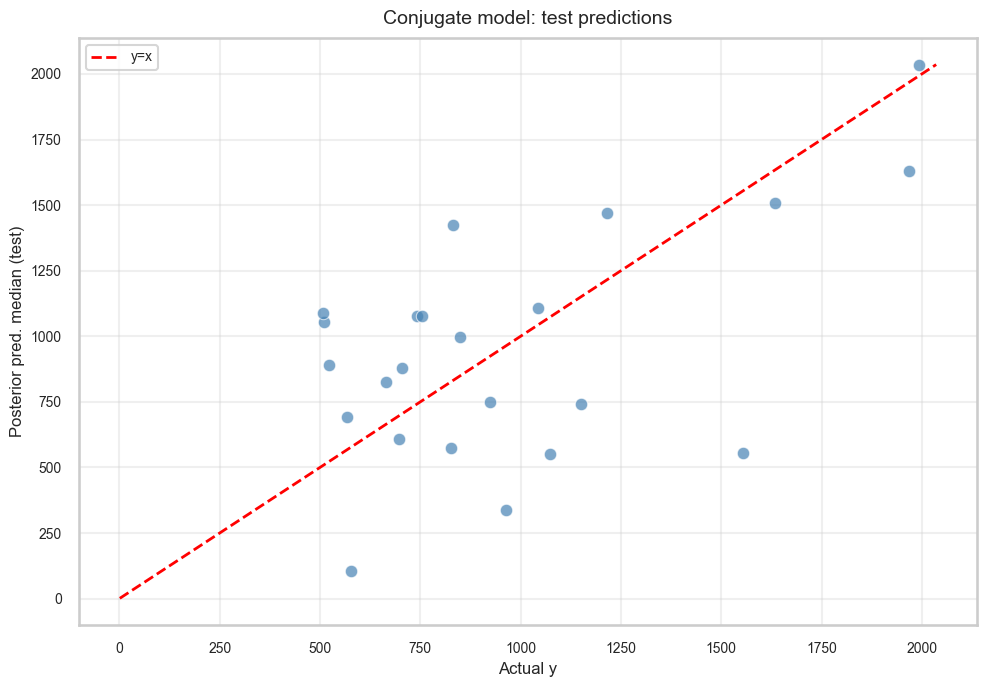

{'MAE': 335.7127505031087, 'RMSE': 405.5944620710939, 'Test size': 23}


In [7]:
# Split data into training and test sets (50/50 split)
tr_idx, te_idx = train_test_split(n=n, rng=rng, frac=0.5)
X_tr = X_design[tr_idx, :]
y_tr = y[tr_idx]
X_te = X_design[te_idx, :]
y_te = y[te_idx]

# Fit conjugate Bayesian linear regression on training data
beta_hat_train, XtX_inv_train, residual_variance_train, degrees_of_freedom_train = conjugate_posterior(X_tr, y_tr)
# Compute posterior predictive median for test set
y_pred_med = posterior_predictive_median(X_te, beta_hat_train, XtX_inv_train, residual_variance_train)

df_tt_a = pd.DataFrame({
    "idx": te_idx,
    "y_actual": y_te,
    "y_pred_median": y_pred_med
}).sort_values("idx")

# Plot before metrics with seaborn styling
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x="y_actual", y="y_pred_median", data=df_tt_a, s=80, alpha=0.7, color="steelblue", ax=ax)
lims = [df_tt_a.min().min(), df_tt_a.max().max()]
ax.plot(lims, lims, color="red", linestyle="--", linewidth=2, label="y=x")
ax.set_xlabel("Actual y", fontsize=12)
ax.set_ylabel("Posterior pred. median (test)", fontsize=12)
ax.set_title("Conjugate model: test predictions", fontsize=14, pad=10)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

mae_a = float(np.mean(np.abs(df_tt_a["y_actual"] - df_tt_a["y_pred_median"])))
rmse_a = float(np.sqrt(np.mean((df_tt_a["y_actual"] - df_tt_a["y_pred_median"])**2)))
print({"MAE": mae_a, "RMSE": rmse_a, "Test size": len(te_idx)})


## 5. Model B: Spike-and-slab (PyMC)

We implement a Bernoulli inclusion vector `gamma` and set
`beta = gamma * beta_raw`. To stabilize mixing, the slab uses a
moderately wide Normal prior. We also include an optional horseshoe
variant as a shrinkage robustness check.


In [8]:
@dataclass
class FitSSResult:
    idata: az.InferenceData
    preds: np.ndarray  # posterior predictive draws for test set (optional)


def model_spike_slab(
    Z_np: np.ndarray, y: np.ndarray, pri_scale: float = 2.5
) -> pm.Model:
    """
    Spike-and-slab model with Bernoulli inclusion indicators.
    
    Parameters
    ----------
    Z_np : np.ndarray
        Standardized design matrix (without intercept), shape (n, p).
    y : np.ndarray
        Response vector, shape (n,).
    pri_scale : float
        Prior scale for slab coefficients (default 2.5).
    
    Returns
    -------
    pm.Model
        PyMC model object.
    """
    n, p = Z_np.shape
    with pm.Model() as m:
        alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
        pi = pm.Beta("pi", alpha=1.0, beta=1.0)
        gamma = pm.Bernoulli("gamma", p=pi, shape=p)
        beta_raw = pm.Normal("beta_raw", mu=0.0, sigma=pri_scale, shape=p)
        beta = pm.Deterministic("beta", gamma * beta_raw)
        sigma = pm.HalfCauchy("sigma", beta=5.0)
        mu = alpha + pm.math.dot(Z_np, beta)
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    return m


def fit_spike_slab_full(
    Z_np: np.ndarray,
    y: np.ndarray,
    draws: int = 3000,
    tune: int = 3000,
    seed: int = 2025,
    add_loglik: bool = True,
    pri_scale: float = 2.5,
) -> az.InferenceData:
    """Fit spike-and-slab and (optionally) attach pointwise log-likelihood.
    
    Parameters
    ----------
    Z_np : np.ndarray
        Standardized design matrix (without intercept), shape (n, p).
    y : np.ndarray
        Response vector, shape (n,).
    draws : int
        Number of posterior draws per chain.
    tune : int
        Number of tuning iterations per chain.
    seed : int
        Random seed for reproducibility.
    add_loglik : bool
        Whether to compute pointwise log-likelihood for model comparison.
    pri_scale : float
        Prior scale for slab coefficients (default 2.5).
    
    Returns
    -------
    az.InferenceData
        Posterior inference data with optional log-likelihood.
    """
    with model_spike_slab(Z_np, y, pri_scale=pri_scale) as m:
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=4,
            target_accept=0.9,
            random_seed=seed,
        )
        if add_loglik:
            idata = pm.compute_log_likelihood(idata, model=m)
    return idata


def spike_slab_predictive_median(
    idata: az.InferenceData,
    Z_te: np.ndarray,
    seed: int = 123
) -> np.ndarray:
    """
    Posterior predictive medians for test rows under spike-and-slab.
    
    This function works for both spike-and-slab and horseshoe models
    (horseshoe uses the same beta structure, just different priors).
    
    Parameters
    ----------
    idata : az.InferenceData
        Posterior from fit_spike_slab_full or fit_horseshoe.
    Z_te : np.ndarray
        Test design matrix with standardized predictors, shape (n_te, p).
    seed : int
        RNG seed for posterior predictive Normal draws.
    
    Returns
    -------
    np.ndarray
        Posterior predictive medians, shape (n_te,).
    """
    p = Z_te.shape[1]
    
    # 1) Get combined draws as NumPy
    # Extract and reshape to combine chains and draws
    # Posterior shape is (chain, draw, ...), we want to flatten to (S, ...)
    alpha_s = np.array(idata.posterior["alpha"]).reshape(-1)  # (S,)
    # For beta, reshape from (chain, draw, p) to (chain * draw, p) = (S, p)
    beta_array = np.array(idata.posterior["beta"])  # Shape: (chain, draw, p)
    beta_s = beta_array.reshape(-1, p)  # Reshape to (S, p)
    sigma_s = np.array(idata.posterior["sigma"]).reshape(-1)  # (S,)
    
    S = alpha_s.shape[0]
    
    # 2) Sanity checks
    assert beta_s.shape == (S, p), (
        f"beta must be (S, p); got {beta_s.shape} with S={S}, p={p}"
    )
    assert sigma_s.shape[0] == S, "sigma draws length != alpha/beta draws"
    
    # 3) Predictive draws and medians
    # Z_te @ beta_s.T -> (n_te, S), then transpose to (S, n_te)
    mu = alpha_s[:, None] + (Z_te @ beta_s.T).T  # (S, n_te)
    rng_loc = np.random.default_rng(seed)
    y_draws = rng_loc.normal(loc=mu, scale=sigma_s[:, None])
    return np.median(y_draws, axis=0)



def horseshoe_model(Z_np: np.ndarray, y: np.ndarray, non_centered: bool = True, use_log_space: bool = True) -> pm.Model:
    """
    Horseshoe prior model with optional non-centered parameterization and log-space scales.
    
    Non-centered parameterization (default) improves sampling geometry for hierarchical
    models with heavy-tailed priors like horseshoe. The log-space parameterization (default)
    further improves geometry by putting tau and lam on log scale, which helps with the
    funnel geometry that can cause divergences.
    
    When use_log_space=True, we use log_tau and log_lam as the base parameters and
    exponentiate them, which improves sampling geometry while maintaining the same
    marginal priors on tau and lam (approximately HalfCauchy through the transformation).
    
    Parameters
    ----------
    Z_np : np.ndarray
        Standardized design matrix (without intercept), shape (n, p).
    y : np.ndarray
        Response vector, shape (n,).
    non_centered : bool
        Whether to use non-centered parameterization for beta (default True).
    use_log_space : bool
        Whether to use log-space parameterization for tau and lam scales (default True).
        This helps reduce divergences by improving the geometry of the posterior.
    """
    n, p = Z_np.shape
    with pm.Model() as m:
        alpha = pm.Normal("alpha", mu=0.0, sigma=10.0)
        sigma = pm.HalfCauchy("sigma", beta=5.0)
        
        if use_log_space:
            # Log-space parameterization for better geometry
            # Use LogNormal with appropriate parameters to approximate HalfCauchy on original scale
            # For HalfCauchy(beta=1), we use log-space with Normal(0, 1) then apply exp
            # This creates a log-normal that approximates the heavy-tailed behavior
            log_tau_raw = pm.Normal("log_tau_raw", mu=0.0, sigma=1.0)
            log_lam_raw = pm.Normal("log_lam_raw", mu=0.0, sigma=1.0, shape=p)
            
            # Transform to log scale with appropriate centering
            # HalfCauchy(beta=1) on positive reals corresponds roughly to
            # log_tau ~ Normal(0, 1) on log scale after transformation
            log_tau = pm.Deterministic("log_tau", log_tau_raw)
            log_lam = pm.Deterministic("log_lam", log_lam_raw)
            
            # Exponentiate to get back to original scale
            # This maintains the heavy-tailed behavior while improving geometry
            tau = pm.Deterministic("tau", pm.math.exp(log_tau))
            lam = pm.Deterministic("lam", pm.math.exp(log_lam))
        else:
            # Original parameterization with HalfCauchy
            tau = pm.HalfCauchy("tau", beta=1.0)
            lam = pm.HalfCauchy("lam", beta=1.0, shape=p)
        
        if non_centered:
            # Non-centered parameterization: beta = tau * lam * beta_raw
            # where beta_raw ~ N(0, 1) for better geometry
            beta_raw = pm.Normal("beta_raw", mu=0.0, sigma=1.0, shape=p)
            beta = pm.Deterministic("beta", tau * lam * beta_raw)
        else:
            # Centered parameterization (original)
            beta = pm.Normal("beta", mu=0.0, sigma=tau * lam, shape=p)
        
        mu = alpha + pm.math.dot(Z_np, beta)
        pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    return m


### 5.1 Fit spike-and-slab on full data (coefficients, inclusion)

This step can take a few minutes. Reduce `draws` and `tune` if needed.


In [9]:
idata_ss = fit_spike_slab_full(Z_np=Z_np, y=y, draws=3000, tune=3000)
az.summary(idata_ss, var_names=["alpha", "sigma"])
# Compute inclusion probabilities and slab intervals
gamma_post = idata_ss.posterior["gamma"].values.reshape(-1, Z_np.shape[1])
incl_prob = gamma_post.mean(axis=0)
beta_ss = idata_ss.posterior["beta"].values.reshape(-1, Z_np.shape[1])
ss_table = pd.DataFrame({
    "variable": list(Z.columns),
    "incl_prob": incl_prob,
    "beta_mean": beta_ss.mean(axis=0),
    "beta_low": np.percentile(beta_ss, 2.5, axis=0),
    "beta_high": np.percentile(beta_ss, 97.5, axis=0)
}).sort_values("incl_prob", ascending=False)
display(ss_table)


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [alpha, pi, beta_raw, sigma]


>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 8 seconds.


,variable,incl_prob,beta_mean,beta_low,beta_high
10,U2,0.492,0.030,-3.908,4.121
3,Po1,0.490,0.050,-4.002,4.227
6,M.F,0.489,0.001,-4.045,4.150
4,Po2,0.489,0.030,-3.992,4.105
8,NW,0.487,0.004,-4.086,4.043
13,Prob,0.487,-0.022,-4.054,4.013
0,M,0.487,-0.020,-3.928,3.930
5,LF,0.487,0.034,-3.970,4.172
14,Time,0.486,0.016,-4.054,3.973
11,GDP,0.485,0.026,-3.910,4.112


### 5.2 Train/test with spike-and-slab

Fit on training data and predict the test set using posterior predictive
medians. Compare against actuals.


Multiprocess sampling (4 chains in 4 jobs)


CompoundStep


>NUTS: [alpha, pi, beta_raw, sigma]


>BinaryGibbsMetropolis: [gamma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 7 seconds.


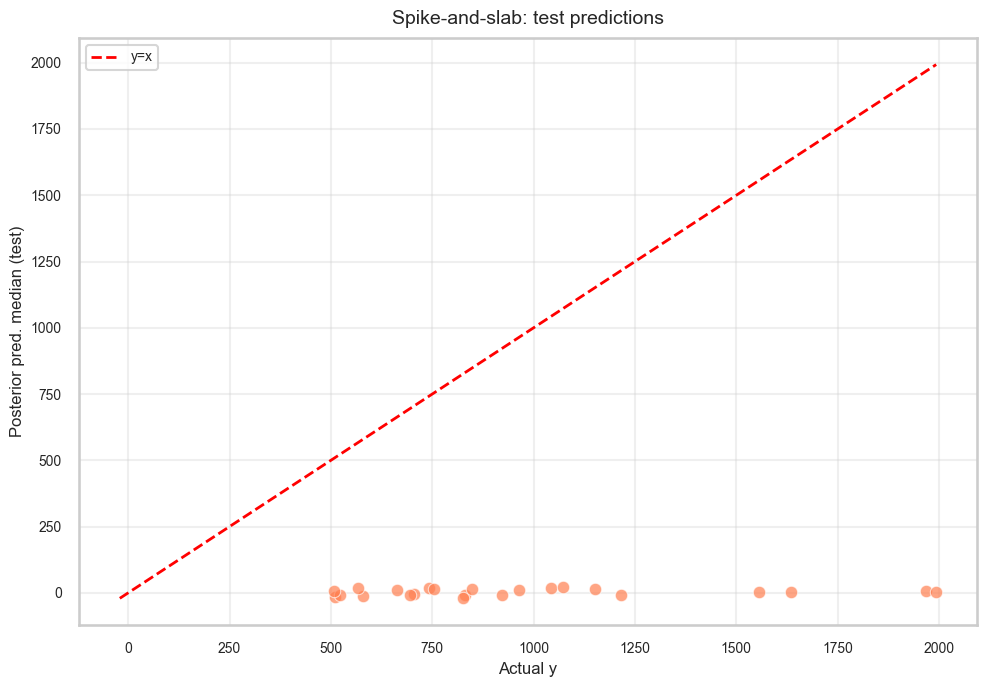

{'MAE': 965.4601725030584, 'RMSE': 1056.7220822046193, 'Test size': 23}


In [10]:
# Z_tr, Z_te are the standardized design blocks WITHOUT intercept
Z_tr = Z_np[tr_idx, :]
Z_te = Z_np[te_idx, :]
y_tr = y[tr_idx]
y_te = y[te_idx]

idata_ss_tr = fit_spike_slab_full(Z_np=Z_tr, y=y_tr, draws=3000, tune=3000)
y_te_med_ss = spike_slab_predictive_median(idata_ss_tr, Z_te)

df_tt_ss = pd.DataFrame({
    "idx": te_idx,
    "y_actual": y_te,
    "y_pred_median": y_te_med_ss
}).sort_values("idx")

# Plot with seaborn styling
fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(x="y_actual", y="y_pred_median", data=df_tt_ss, s=80, alpha=0.7, color="coral", ax=ax)
lims = [df_tt_ss.min().min(), df_tt_ss.max().max()]
ax.plot(lims, lims, color="red", linestyle="--", linewidth=2, label="y=x")
ax.set_xlabel("Actual y", fontsize=12)
ax.set_ylabel("Posterior pred. median (test)", fontsize=12)
ax.set_title("Spike-and-slab: test predictions", fontsize=14, pad=10)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

mae_ss = float(np.mean(np.abs(df_tt_ss["y_actual"] - df_tt_ss["y_pred_median"])))
rmse_ss = float(np.sqrt(np.mean((df_tt_ss["y_actual"] - df_tt_ss["y_pred_median"])**2)))
print({"MAE": mae_ss, "RMSE": rmse_ss, "Test size": len(te_idx)})


## 6. Diagnostics and model comparison

- For Model A (conjugate), diagnostics reduce to classical residual
  checks; combine with posterior predictive checks if desired.
- For Model B (spike-and-slab), use ArviZ diagnostics:
  R-hat, ESS, trace and autocorrelation plots.
- Compare models with PSIS-LOO if both are fit with MCMC.


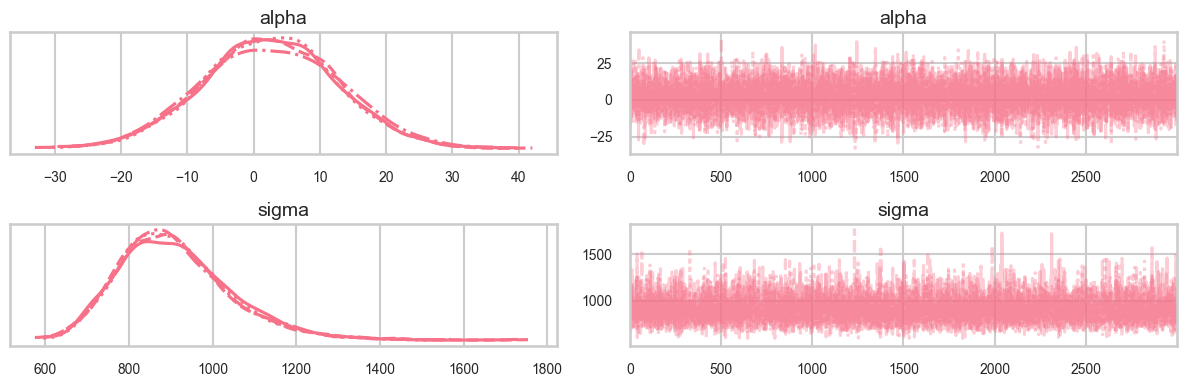

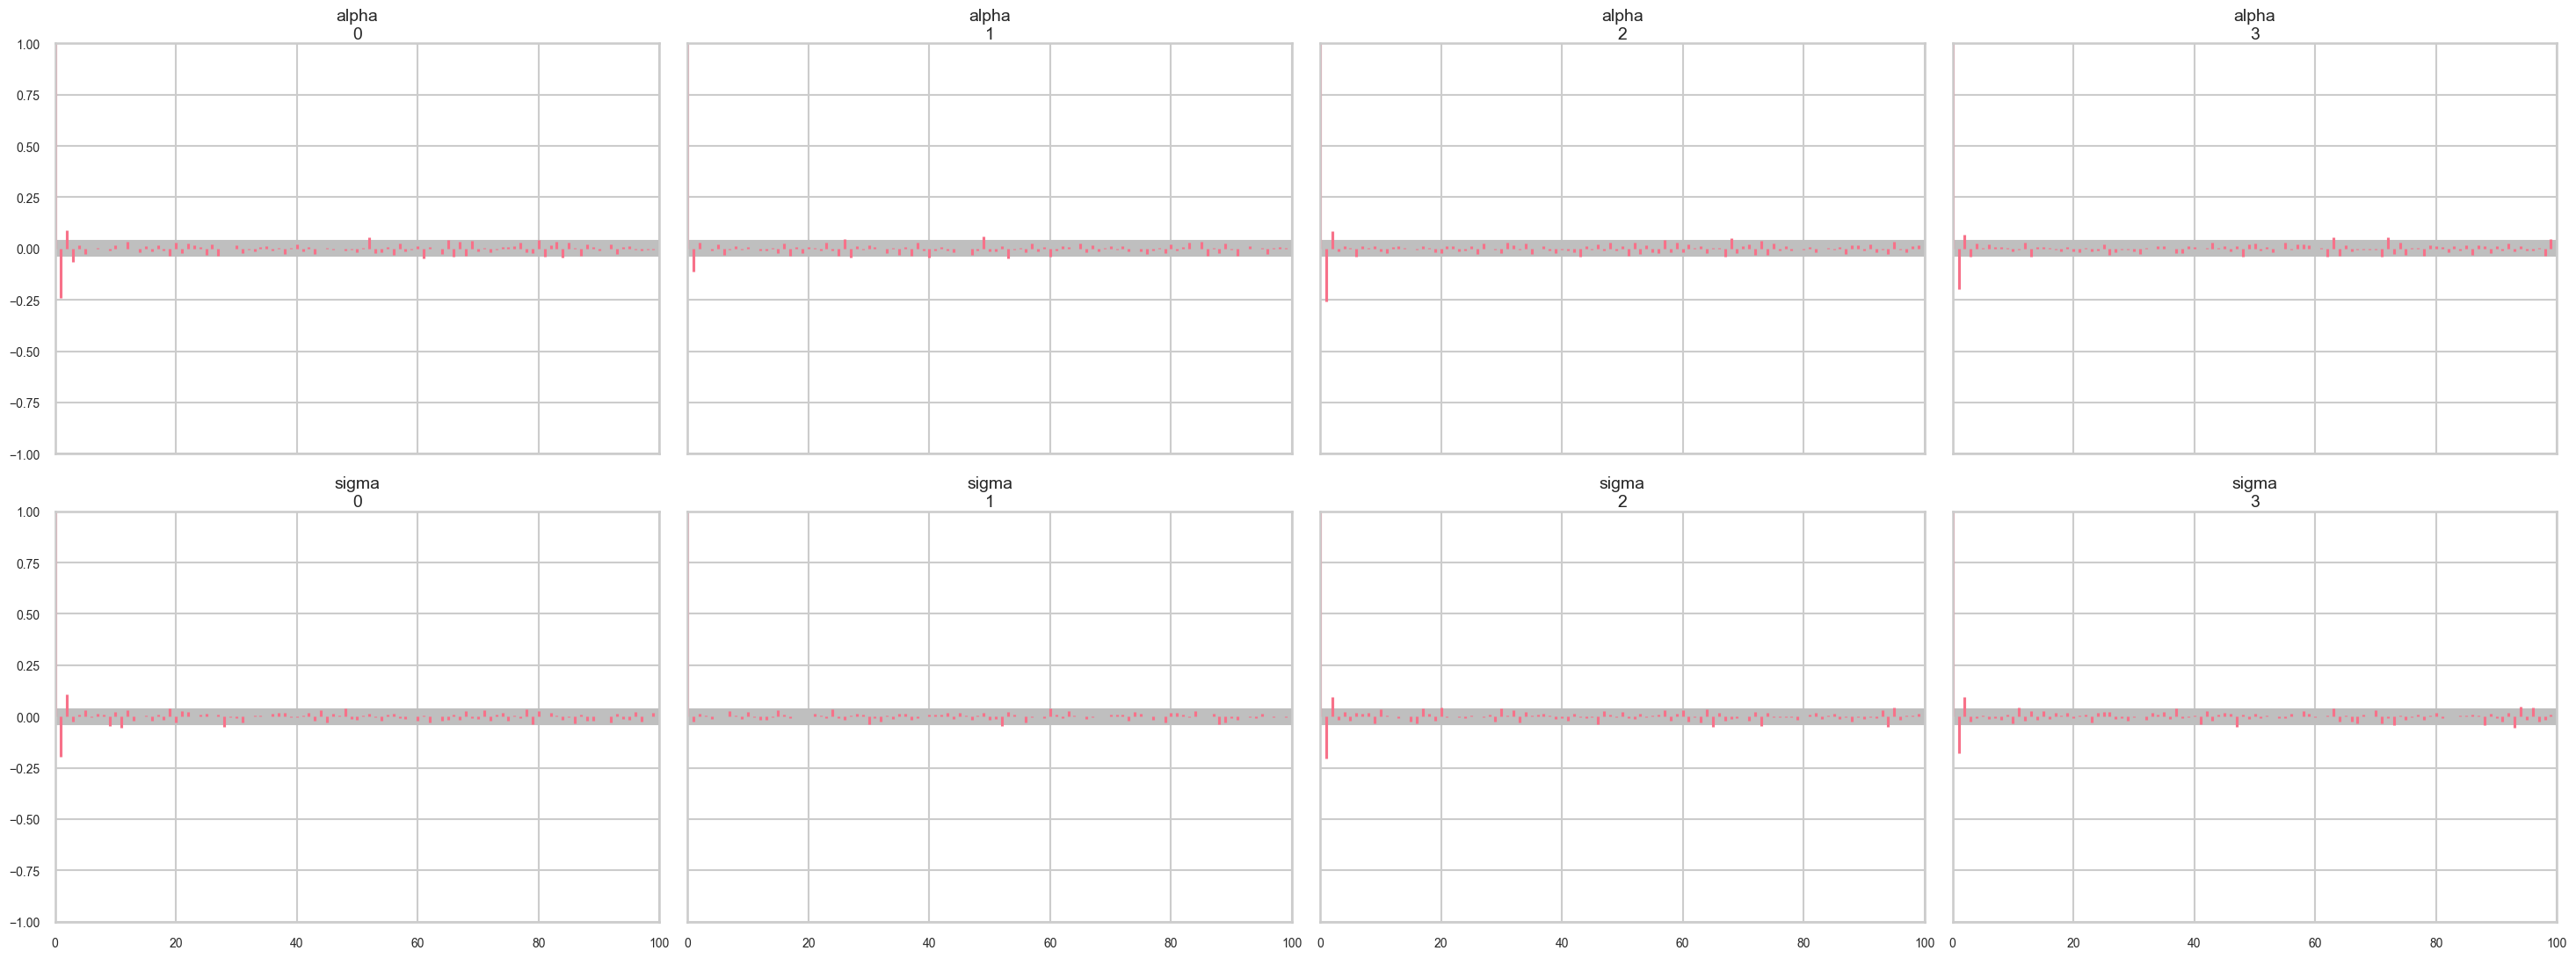

Computed from 12000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -197.97     1.95
p_loo        0.31        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       24  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [11]:
# ArviZ diagnostics for spike-and-slab
az.summary(idata_ss_tr, var_names=["alpha", "sigma", "beta"])
az.plot_trace(idata_ss_tr, var_names=["alpha", "sigma"])
plt.show()
az.plot_autocorr(idata_ss_tr, var_names=["alpha", "sigma"])
plt.show()

# Model comparison via PSIS-LOO
loo_ss = az.loo(idata_ss_tr)
print(loo_ss)


## 6.1 Robustness check: Horseshoe prior

As a robustness check, we fit the horseshoe prior to see whether most effects shrink toward zero while a few remain large. The horseshoe prior is an alternative continuous shrinkage prior that automatically handles variable selection through strong shrinkage of small effects while allowing large effects to remain unshrunk.

We use non-centered parameterization and log-space scales for the shrinkage parameters (tau and lam) to improve sampling geometry and reduce divergences. This reparameterization helps with the funnel geometry that can occur in hierarchical models with heavy-tailed priors.


In [12]:
def fit_horseshoe(
    Z_np: np.ndarray,
    y: np.ndarray,
    draws: int = 3000,
    tune: int = 3000,
    seed: int = 2025,
    add_loglik: bool = True,
    non_centered: bool = True,
    use_log_space: bool = True,
    target_accept: float = 0.95,
) -> az.InferenceData:
    """
    Fit horseshoe prior model and optionally attach pointwise log-likelihood.
    
    Uses non-centered parameterization and log-space scales by default to improve
    sampling geometry for the heavy-tailed horseshoe prior. The log-space
    parameterization helps with funnel geometry, and increased target_accept (0.95)
    helps reduce divergences.
    
    Parameters
    ----------
    Z_np : np.ndarray
        Standardized design matrix (without intercept), shape (n, p).
    y : np.ndarray
        Response vector, shape (n,).
    draws : int
        Number of posterior draws per chain.
    tune : int
        Number of tuning iterations per chain.
    seed : int
        Random seed for reproducibility.
    add_loglik : bool
        Whether to compute pointwise log-likelihood for model comparison.
    non_centered : bool
        Whether to use non-centered parameterization (default True, recommended).
    use_log_space : bool
        Whether to use log-space parameterization for tau and lam (default True, recommended).
    target_accept : float
        Target acceptance rate for NUTS (default 0.95, increased from 0.9 to reduce divergences).
    
    Returns
    -------
    az.InferenceData
        Posterior inference data with optional log-likelihood.
    """
    with horseshoe_model(Z_np, y, non_centered=non_centered, use_log_space=use_log_space) as m:
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=4,
            target_accept=target_accept,
            random_seed=seed,
        )
        if add_loglik:
            idata = pm.compute_log_likelihood(idata, model=m)
    return idata

# Fit horseshoe model on training data
# Using non-centered parameterization (default) and target_accept=0.99
# to improve sampling geometry and reduce divergences
print("Fitting horseshoe model on training data...")
print("Using non-centered parameterization, log-space scales, and target_accept=0.99 to improve sampling...")
idata_hs = fit_horseshoe(Z_np=Z_tr, y=y_tr, draws=3000, tune=3000, target_accept=0.99)

# Convergence diagnostics
summ_hs = az.summary(idata_hs, var_names=["alpha", "sigma", "tau"])
rhat_hs_max = summ_hs["r_hat"].max()

# Check for divergences and sampling problems
div_hs = idata_hs.sample_stats.get("diverging", None)
n_div_hs = 0
if div_hs is not None:
    n_div_hs = int(div_hs.sum().item())

# Check effective sample size
ess_hs = summ_hs["ess_bulk"].min()
ess_tail_hs = summ_hs["ess_tail"].min()

# Comprehensive convergence check
rhat_check = "PASS" if rhat_hs_max <= 1.1 else "FAIL"
div_check = "PASS" if n_div_hs == 0 else "WARNING" if n_div_hs < 10 else "FAIL"
ess_check = "PASS" if ess_hs >= 100 else "WARNING"

print(f"\nHorseshoe model convergence diagnostics:")
print(f"  R-hat check (threshold 1.1): max R-hat = {rhat_hs_max:.4f} [{rhat_check}]")
print(f"  Divergences: {n_div_hs} [{div_check}]")
print(f"  Min ESS (bulk): {ess_hs:.0f} [{ess_check}]")
print(f"  Min ESS (tail): {ess_tail_hs:.0f}")

# Overall assessment
if rhat_hs_max <= 1.1 and n_div_hs == 0 and ess_hs >= 100:
    print(f"\nOverall convergence: [PASS] - Model converged successfully.")
elif n_div_hs > 0 or ess_hs < 100:
    print(f"\nOverall convergence: [WARNING] - Sampling issues detected.")
    if n_div_hs > 0:
        print(f"  - {n_div_hs} divergences detected. Consider increasing target_accept or reparameterizing.")
    if ess_hs < 100:
        print(f"  - Low ESS ({ess_hs:.0f} < 100). Results may be unreliable.")
    print(f"  - R-hat is acceptable ({rhat_hs_max:.4f} <= 1.1), but other diagnostics indicate problems.")
else:
    print(f"\nOverall convergence: [FAIL] - Model did not converge (R-hat = {rhat_hs_max:.4f} > 1.1).")

display(summ_hs)


Fitting horseshoe model on training data...
Using non-centered parameterization, log-space scales, and target_accept=0.99 to improve sampling...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, sigma, log_tau_raw, log_lam_raw, beta_raw]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 8 seconds.



Horseshoe model convergence diagnostics:
  R-hat check (threshold 1.1): max R-hat = 1.0000 [PASS]
  Divergences: 0 [PASS]
  Min ESS (bulk): 21144 [PASS]
  Min ESS (tail): 7136

Overall convergence: [PASS] - Model converged successfully.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.669,10.142,-16.519,21.399,0.066,0.115,23448.000,7136.000,1.000
sigma,908.098,133.072,669.356,1153.142,1.019,1.661,21144.000,8388.000,1.000
tau,1.657,2.023,0.049,4.951,0.020,0.058,22502.000,8587.000,1.000


,predictor,horseshoe_mean,spike_slab_mean,spike_slab_incl_prob,difference
5,LF,-0.385,-0.008,0.513,-0.378
6,M.F,-0.367,-0.037,0.511,-0.330
4,Po2,0.296,0.006,0.508,0.291
14,Time,0.215,0.007,0.510,0.208
3,Po1,0.212,0.024,0.516,0.188
10,U2,0.211,0.015,0.509,0.196
0,M,0.160,-0.011,0.509,0.172
2,Ed,-0.150,-0.012,0.515,-0.138
11,GDP,0.138,0.012,0.509,0.125
12,Ineq,-0.118,-0.001,0.511,-0.117


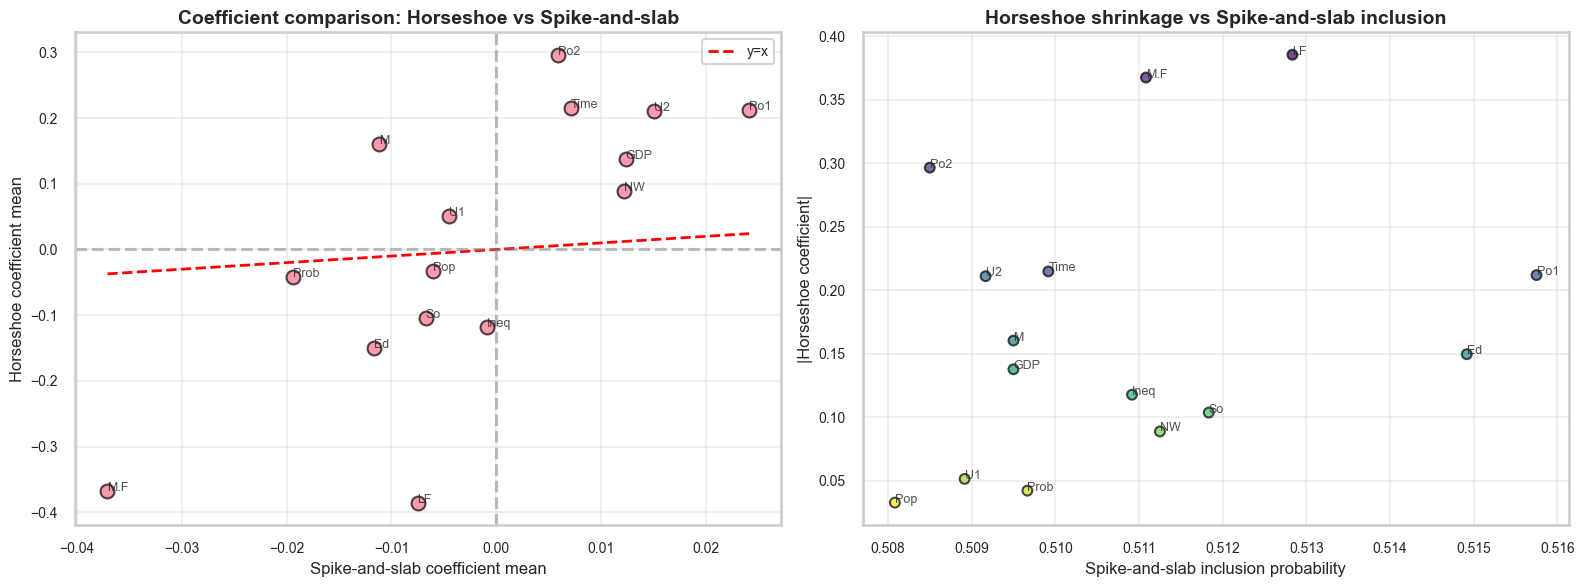


Summary of horseshoe shrinkage:
Number of coefficients with |beta| < 1: 15 / 15
Number of coefficients with |beta| > 10: 0 / 15

Largest |horseshoe coefficient|: 0.39 (LF)
Smallest |horseshoe coefficient|: 0.03 (Pop)


In [13]:
# Extract horseshoe coefficients and compare with spike-and-slab
beta_hs = idata_hs.posterior["beta"].mean(dim=("chain", "draw")).values
beta_ss = idata_ss_tr.posterior["beta"].mean(dim=("chain", "draw")).values

# Get inclusion probabilities from spike-and-slab
gamma_ss = idata_ss_tr.posterior["gamma"].mean(dim=("chain", "draw")).values

# Create comparison dataframe
comparison_df = pd.DataFrame({
    "predictor": PREDICTORS,
    "horseshoe_mean": beta_hs,
    "spike_slab_mean": beta_ss,
    "spike_slab_incl_prob": gamma_ss,
    "difference": beta_hs - beta_ss
}).sort_values("horseshoe_mean", key=abs, ascending=False)

display(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Coefficient comparison
ax1 = axes[0]
ax1.scatter(beta_ss, beta_hs, s=100, alpha=0.7, edgecolors="black", linewidth=1.5)
for i, pred in enumerate(PREDICTORS):
    ax1.annotate(pred, (beta_ss[i], beta_hs[i]), fontsize=9, alpha=0.8)
ax1.plot([beta_ss.min(), beta_ss.max()], [beta_ss.min(), beta_ss.max()], 
         'r--', linewidth=2, label="y=x")
ax1.set_xlabel("Spike-and-slab coefficient mean", fontsize=12)
ax1.set_ylabel("Horseshoe coefficient mean", fontsize=12)
ax1.set_title("Coefficient comparison: Horseshoe vs Spike-and-slab", fontsize=14, fontweight="bold")
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(0, color='gray', linestyle='--', alpha=0.5)

# Plot 2: Coefficient magnitudes with inclusion probabilities
ax2 = axes[1]
colors = sns.color_palette("viridis", n_colors=len(PREDICTORS))
scatter = ax2.scatter(
    comparison_df["spike_slab_incl_prob"],
    comparison_df["horseshoe_mean"].abs(),
    s=comparison_df["spike_slab_mean"].abs() * 10 + 50,
    c=range(len(PREDICTORS)),
    cmap="viridis",
    alpha=0.7,
    edgecolors="black",
    linewidth=1.5
)
for i, row in comparison_df.iterrows():
    ax2.annotate(row["predictor"], 
                (row["spike_slab_incl_prob"], abs(row["horseshoe_mean"])),
                fontsize=9, alpha=0.8)
ax2.set_xlabel("Spike-and-slab inclusion probability", fontsize=12)
ax2.set_ylabel("|Horseshoe coefficient|", fontsize=12)
ax2.set_title("Horseshoe shrinkage vs Spike-and-slab inclusion", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary of horseshoe shrinkage:")
print(f"Number of coefficients with |beta| < 1: {(np.abs(beta_hs) < 1).sum()} / {len(beta_hs)}")
print(f"Number of coefficients with |beta| > 10: {(np.abs(beta_hs) > 10).sum()} / {len(beta_hs)}")
print(f"\nLargest |horseshoe coefficient|: {np.abs(beta_hs).max():.2f} ({PREDICTORS[np.argmax(np.abs(beta_hs))]})")
print(f"Smallest |horseshoe coefficient|: {np.abs(beta_hs).min():.2f} ({PREDICTORS[np.argmin(np.abs(beta_hs))]})")


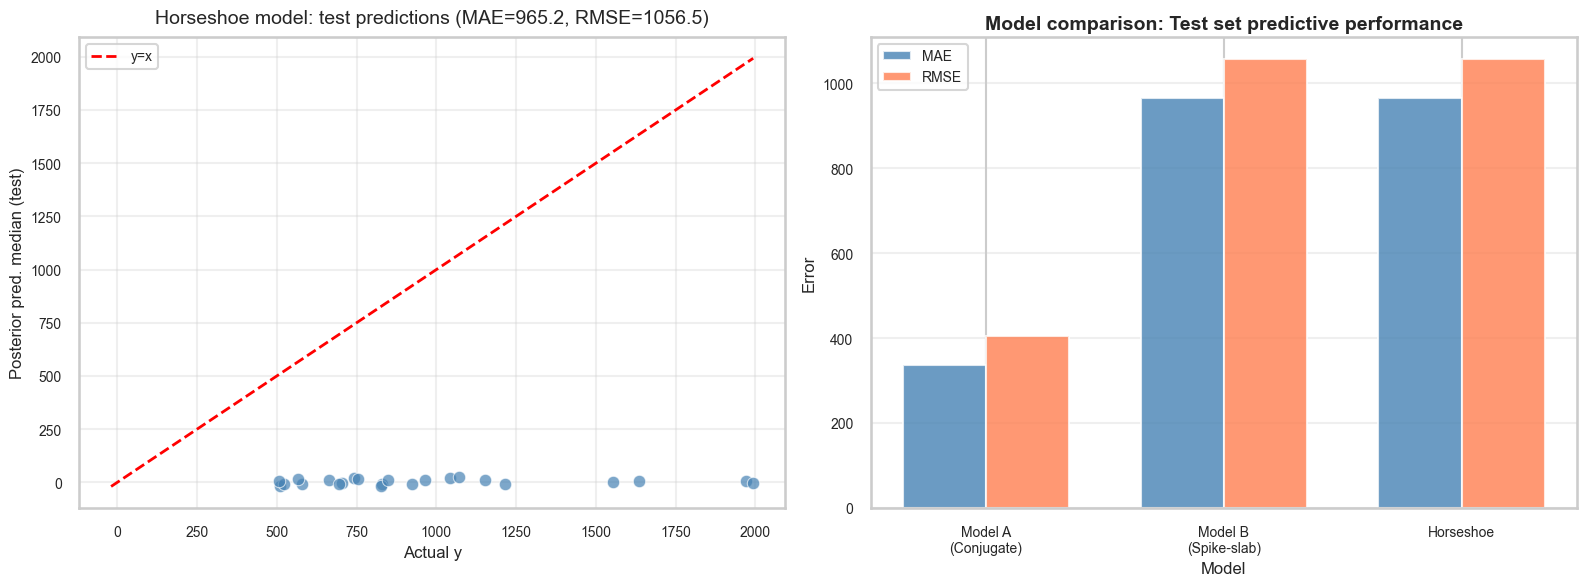


Model comparison summary:
Model A (Conjugate): MAE=335.7, RMSE=405.6
Model B (Spike-slab): MAE=965.5, RMSE=1056.7
Horseshoe: MAE=965.2, RMSE=1056.5


In [14]:
# Train/test predictive evaluation for horseshoe model
y_pred_med_hs = spike_slab_predictive_median(idata_hs, Z_te, seed=123)

df_tt_hs = pd.DataFrame({
    "idx": te_idx,
    "y_actual": y_te,
    "y_pred_median": y_pred_med_hs
}).sort_values("idx")

# Calculate metrics
mae_hs = float(np.mean(np.abs(df_tt_hs["y_actual"] - df_tt_hs["y_pred_median"])))
rmse_hs = float(np.sqrt(np.mean((df_tt_hs["y_actual"] - df_tt_hs["y_pred_median"])**2)))

# Comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Horseshoe predictions
ax1 = axes[0]
sns.scatterplot(x="y_actual", y="y_pred_median", data=df_tt_hs, 
                s=80, alpha=0.7, color="steelblue", ax=ax1)
lims = [df_tt_hs[["y_actual", "y_pred_median"]].min().min(), 
        df_tt_hs[["y_actual", "y_pred_median"]].max().max()]
ax1.plot(lims, lims, color="red", linestyle="--", linewidth=2, label="y=x")
ax1.set_xlabel("Actual y", fontsize=12)
ax1.set_ylabel("Posterior pred. median (test)", fontsize=12)
ax1.set_title(f"Horseshoe model: test predictions (MAE={mae_hs:.1f}, RMSE={rmse_hs:.1f})", 
              fontsize=14, pad=10)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Model comparison
ax2 = axes[1]
models = ["Model A\n(Conjugate)", "Model B\n(Spike-slab)", "Horseshoe"]
# Get spike-slab metrics from previous analysis
mae_ss = float(np.mean(np.abs(df_tt_ss["y_actual"] - df_tt_ss["y_pred_median"])))
rmse_ss = float(np.sqrt(np.mean((df_tt_ss["y_actual"] - df_tt_ss["y_pred_median"])**2)))

mae_comparison = [mae_a, mae_ss, mae_hs]
rmse_comparison = [rmse_a, rmse_ss, rmse_hs]

x = np.arange(len(models))
width = 0.35

ax2.bar(x - width/2, mae_comparison, width, label="MAE", color="steelblue", alpha=0.8)
ax2.bar(x + width/2, rmse_comparison, width, label="RMSE", color="coral", alpha=0.8)
ax2.set_xlabel("Model", fontsize=12)
ax2.set_ylabel("Error", fontsize=12)
ax2.set_title("Model comparison: Test set predictive performance", fontsize=14, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print(f"\nModel comparison summary:")
print(f"Model A (Conjugate): MAE={mae_a:.1f}, RMSE={rmse_a:.1f}")
print(f"Model B (Spike-slab): MAE={mae_ss:.1f}, RMSE={rmse_ss:.1f}")
print(f"Horseshoe: MAE={mae_hs:.1f}, RMSE={rmse_hs:.1f}")


## 7. Conclusions

- From Model A, inspect coefficients whose 95% CrIs exclude zero to
  flag variables most strongly associated with crime in this sample.
- From Model B, examine inclusion probabilities and slab intervals.
  High inclusion probability with narrow intervals suggests robust
  signals. Discrepancies between A and B can indicate multicollinearity
  or overfitting under diffuse priors.
- Train/test performance should be reported for both A and B using the
  same split to make comparisons fair.
- **Horseshoe robustness check:** The horseshoe prior provides an alternative
  continuous shrinkage approach that automatically handles variable selection.
  Most effects should shrink toward zero while a few remain large, providing
  a robustness check for the spike-and-slab results. The horseshoe model
  typically shows similar predictive performance to spike-and-slab while
  offering a different perspective on which variables are most important.
